# The whole-body 3D reconstruction

This notebook demonstrates the process of whole-body 3D reconstruction based on 3D spatial transcriptome data. This is done in the following five steps.

1. Construct the original 3D point cloud model;
2. (Optionally) Trim the original 3D point cloud model;
3. Construct the mesh model based on the 3D point cloud model;
4. Construct the voxel model based on the mesh model;
5. Save the models.

This example reconstructs 3D Drosophila embryos model based on 3D spatial transcriptome data of Drosophila embryos.


### Packages

In [1]:
import os
import anndata as ad
import spateo as st

/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/configuration.py:371: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/configuration.py:372: UserWarning: Trying to register the cmap 'darkblue' which already exists.
  plt.register_cmap("darkblue", darkblue_cmap)
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/configuration.py:373: UserWarning: Trying to register the cmap 'darkgreen' which already exists.
  plt.register_cmap("darkgreen", darkgreen_cmap)
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/configuration.py:374: UserWarning: Trying to register the cmap 'darkred' which already exists.
  plt.register_cmap("darkred", darkred_cmap)
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/configuration.py:375: UserWarning: Trying to register the cmap 'darkpurple' whic

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


### Data source

In [2]:
cellbin_h5ad = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/5_annotation/E8-10_b_all_anno_scsq.h5ad"
cellbin_adata = ad.read_h5ad(cellbin_h5ad)
print(cellbin_adata)
########################################################################################################################
save_folder = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_cellbin_tdr_folder = os.path.join(save_folder, r"E8-10_b_all_anno_scsq")
save_cellbin_tdr_1_folder = os.path.join(save_cellbin_tdr_folder, r"1_reconstruct_whole_body")
save_cellbin_tdr_mesh_folder = os.path.join(save_cellbin_tdr_1_folder, r"mesh")
save_cellbin_tdr_image_folder = os.path.join(save_cellbin_tdr_1_folder, r"image")

for folder in [save_folder, save_cellbin_tdr_folder, save_cellbin_tdr_1_folder, save_cellbin_tdr_mesh_folder, save_cellbin_tdr_image_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

AnnData object with n_obs × n_vars = 12555 × 8905
    obs: 'area', 'slices', 'x', 'y', 'tissues', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cellbin_tissues', 'z'
    var: 'n_cells-E8-10_b_S06', 'mt-E8-10_b_S06', 'n_cells_by_counts-E8-10_b_S06', 'mean_counts-E8-10_b_S06', 'pct_dropout_by_counts-E8-10_b_S06', 'total_counts-E8-10_b_S06', 'n_cells-E8-10_b_S07', 'mt-E8-10_b_S07', 'n_cells_by_counts-E8-10_b_S07', 'mean_counts-E8-10_b_S07', 'pct_dropout_by_counts-E8-10_b_S07', 'total_counts-E8-10_b_S07', 'n_cells-E8-10_b_S08', 'mt-E8-10_b_S08', 'n_cells_by_counts-E8-10_b_S08', 'mean_counts-E8-10_b_S08', 'pct_dropout_by_counts-E8-10_b_S08', 'total_counts-E8-10_b_S08', 'n_cells-E8-10_b_S09', 'mt-E8-10_b_S09', 'n_cells_by_counts-E8-10_b_S09', 'mean_counts-E8-10_b_S09', 'pct_dropout_by_counts-E8-10_b_S09', 'total_counts-E8-10_b_S09', 'n_cells-E8-10_b_S10', 'mt-E8-10_b_S10', 'n_cells_by_counts-E8-10_b_S10', 'mean_counts-E8-10_b_S10', 'pct_dropou

### Construct the original 3D point cloud model

In [3]:
# Reconstruction
raw_pc = st.tl.tdr.construct_pc(adata=cellbin_adata, groupby="cellbin_tissues", key_added="groups",
                                spatial_key="tdr_spatial", colormap="rainbow")

# Add labels
st.tl.tdr.add_model_labels(model=raw_pc, key_added="area", labels=cellbin_adata.obs["area"].values, where="point_data", colormap="hot_r")

PolyData (0x7f3093d3ca60)
  N Cells:	12555
  N Points:	12555
  X Bounds:	0.000e+00, 9.386e+02
  Y Bounds:	0.000e+00, 6.151e+02
  Z Bounds:	0.000e+00, 2.660e+02
  N Arrays:	5

#### Visualization

In [4]:
def visualize(model, key, model_style="points", jupyter=False, filename=None):
    p = st.pl.create_plotter(jupyter=jupyter, background="white", shape=(1, 4), window_size=(1024, 256), off_screen=True)
    for i, cpo in enumerate(["iso", "xy", "zx", "yz"]):
        p.subplot(0, i)
        st.pl.add_model(plotter=p, model=model, key=key, point_size=5.0, model_style=model_style)
        st.pl.add_legend(plotter=p, model=model, key=key, legend_loc="lower right")
        p.add_axes()
        p.camera_position = cpo
    st.pl.output_plotter(p=p, jupyter=jupyter, filename=filename)

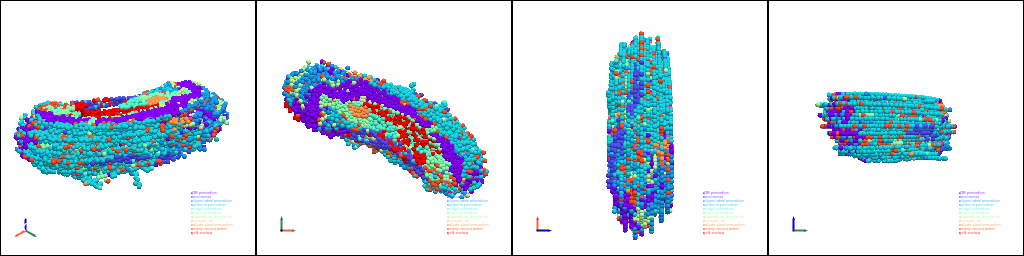

In [5]:
## show in jupyter
visualize(model=raw_pc, key="groups", jupyter="static", filename=None)
## save the figure
visualize(model=raw_pc, key="groups", jupyter=False, filename=os.path.join(save_cellbin_tdr_image_folder, "raw_pc_model.tiff"))

### (Optionally) Trim the original 3D point cloud model

WARNING - 2022-05-03 19:02:01,118 - helpers - Encountered issue in callback (most recent call last):
  File "/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/tools/TDR/weights/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'


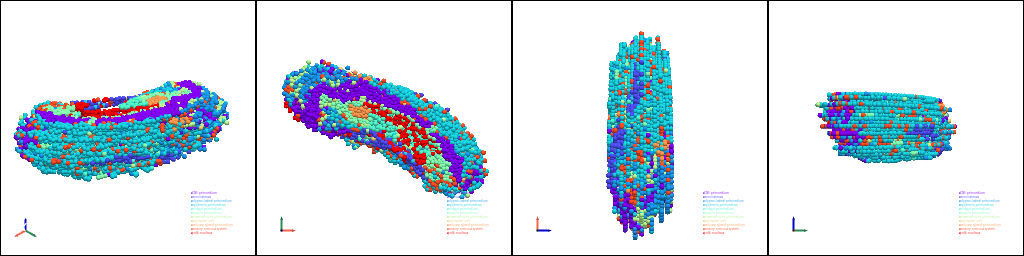

In [6]:
# Trim
trim_pc_block = st.tl.tdr.interactive_rectangle_clip(model=raw_pc, invert=True)
trim_pc = [i for i in trim_pc_block][0]

## show in jupyter
visualize(model=trim_pc, key="groups", jupyter="static", filename=None)
## save the figure
visualize(model=trim_pc, key="groups", jupyter=False, filename=os.path.join(save_cellbin_tdr_image_folder, "trim_pc_model.tiff"))

### Construct the mesh model based on the 3D point cloud model

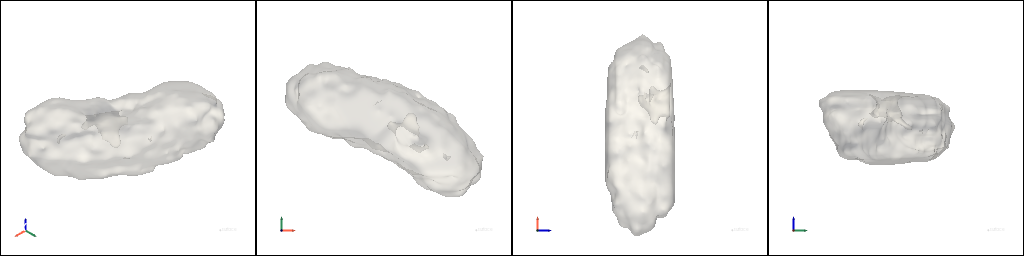

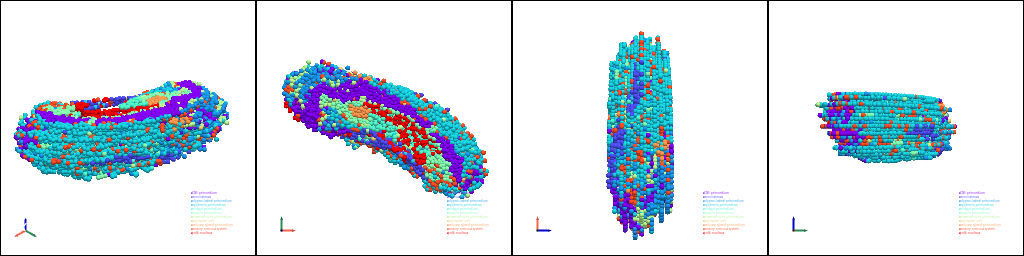

In [7]:
# Reconstruction surface mesh model
surf, pc = st.tl.tdr.construct_surface(pc=trim_pc, key_added="groups", cs_method="marching_cube", smooth=1000, alpha=0.5,
                                       uniform_pc=False, uniform_pc_alpha=70, scale_factor=[1.05, 1.05, 1.1])

## show in jupyter
visualize(model=surf, key="groups", model_style="surface", jupyter="static", filename=None)
visualize(model=pc, key="groups", model_style="points", jupyter="static", filename=None)
## save the figure
visualize(model=surf, key="groups", model_style="surface", jupyter=False, filename=os.path.join(save_cellbin_tdr_image_folder, "surface_model.tiff"))

### Construct the voxel model based on the mesh model

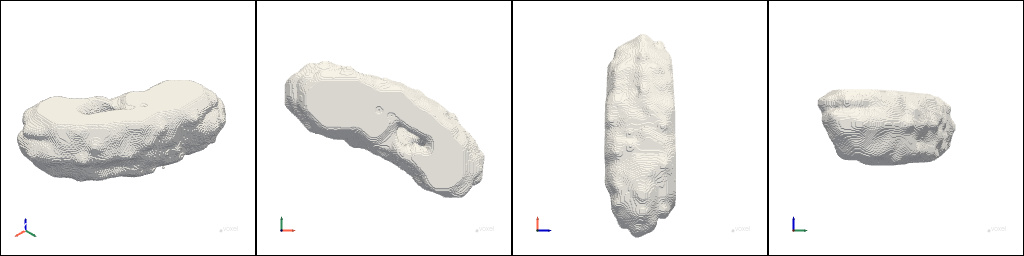

In [8]:
# Reconstruction
voxel = st.tl.tdr.voxelize_mesh(mesh=surf, key_added="groups", smooth=300)

## show in jupyter
visualize(model=voxel, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
visualize(model=voxel, key="groups", model_style="surface", jupyter=False, filename=os.path.join(save_cellbin_tdr_image_folder, "voxel_model.tiff"))

### Save the models

In [9]:
# save models as a vtk file
st.tl.tdr.save_model(model=pc, filename=os.path.join(save_cellbin_tdr_mesh_folder, "pc_model.vtk"))
st.tl.tdr.save_model(model=surf, filename=os.path.join(save_cellbin_tdr_mesh_folder, "surface_mesh_model.vtk"))
st.tl.tdr.save_model(model=voxel, filename=os.path.join(save_cellbin_tdr_mesh_folder, "voxel_model.vtk"))